In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
from sklearn.decomposition import PCA
import seaborn as sns
import os

In [4]:
# Function to load and preprocess the dataset
def load_and_preprocess_data(data):
    # Load the data, skipping the first row (header=1)
    data = data.round(5)
    cols = data.columns
        
    # Standardize the data (Z-score normalization)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)
    
    return X_scaled, scaler, cols

In [5]:
# Function to build the non-linear PCA model with specified architecture
def build_nonlinear_pca_model(input_dim, encoding_dim):
    # Define layer sizes
    a = input_dim  # First layer size (same as input features)
    b = 9  # Second layer size
    n = encoding_dim  # Bottleneck layer size
    
    # Input layer
    input_layer = Input(shape=(a,))
    # Encoder
    encoder_layer1 = Dense(a, activation='linear')(input_layer)  # First layer - non-linear (a neurons)
    encoder_layer2 = Dense(b, activation='elu')(encoder_layer1)  # Second layer - non-linear (b neurons)
    # Bottleneck layer
    bottleneck = Dense(n, activation='linear')(encoder_layer2)  # Third layer - linear (n neurons)
    # Decoder
    decoder_layer1 = Dense(b, activation='elu')(bottleneck)  # Fourth layer - non-linear (b neurons)
    decoder_layer2 = Dense(a, activation='linear')(decoder_layer1)  # Fifth layer - non-linear (a neurons)
    
    # Define the model
    autoencoder = Model(inputs=input_layer, outputs=decoder_layer2)
    encoder = Model(inputs=input_layer, outputs=bottleneck)
    return autoencoder, encoder

In [6]:
# Function to train the model
def train_model(autoencoder, X_scaled, epochs=1000, batch_size=32):
    """
    Train the autoencoder model
    """
    # Compile the model
    autoencoder.compile(optimizer='adam', loss='mse')           # Optimizer: Adam (adaptive learning rate for better convergence)
    
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)      # stops training if validation loss doesn’t improve for 10 epochs
    
    # Train the model
    history = autoencoder.fit(
        X_scaled, X_scaled,
        epochs=epochs,
        batch_size=batch_size,          # Number of samples processed before updating weights
        shuffle=False,                   # Shuffle the data at each epoch to prevent learning order-specific patterns
        validation_split=0.2,           # 20% of the data is used for validation set
        callbacks=[early_stop]
    )
    # It will print the loss(value of cost function for your training data) and the val_loss(value of cost function for your validation data) for each epoch. 

    return history


In [7]:
# Function to evaluate the model and calculate explained variance
def evaluate_model(encoder, autoencoder, X_scaled):
    """
    Evaluate the model by calculating the explained variance and reconstruction error
    """
    # Get the encoded representation
    encoded_data = encoder.predict(X_scaled)          # Could we reconstruct data on lower PCs using this?
    
    # Get the reconstructed data
    reconstructed_data = autoencoder.predict(X_scaled)
    
    # Calculate reconstruction error (MSE)
    mse = np.mean(np.square(X_scaled - reconstructed_data))
    
    # Calculate variance explained by autoencoder
    # This is an approximation based on the reconstruction error
    total_variance = np.var(X_scaled, axis=0).sum()
    unexplained_variance = np.var(X_scaled - reconstructed_data, axis=0).sum()
    explained_variance_ratio = 1 - (unexplained_variance / total_variance)
    # Calculate information loss
    information_loss = 1 - explained_variance_ratio         # autoencoder's reconstruction loss
    
    # Print required metrics
    print(f"\nOriginal dataset shape: {X_scaled.shape}")
    print(f"Derived dataset shape: {encoded_data.shape}")
    print(f"Reconstruction MSE: {mse*100:.4f}%")
    print(f"Information loss after feature extraction: {information_loss*100:.2f}%")
    print(f"Explained variance ratio (estimated based on autoencoder): {explained_variance_ratio*100:.2f}%\n")
    
    return encoded_data, reconstructed_data, explained_variance_ratio


In [8]:
# Function to plot required visualizations
def plot_visualizations(X_scaled, encoded_data, feature_names):
    """
    Plot the scree plot and correlation map between original features and PCs
    Display on screen instead of saving
    """
    # # 1. Scree plot (Variance explained by each PC)
    #### We are currently using pca_variance for plotting this graph and not nlpca_variance. 

    # plt.figure(figsize=(10, 6))
    # plt.bar(range(1, len(pca_variance) + 1), pca_variance, alpha=0.7)
    # plt.plot(range(1, len(pca_variance) + 1), np.cumsum(pca_variance), 'r-o')
    # plt.axhline(y=0.9, color='g', linestyle='--')
    # plt.title('Scree Plot: Variance Explained by Principal Components')
    # plt.xlabel('Principal Component')
    # plt.ylabel('Proportion of Variance Explained')
    # plt.xticks(range(1, len(pca_variance) + 1))
    # plt.legend(['Cumulative Explained Variance', 'Individual Explained Variance', '90% Explained Variance'])
    # plt.grid(True, alpha=0.3)
    # plt.tight_layout()
    # plt.show()
    
    # 2. Correlation map between original features and PCs
    # Create numpy arrays from the data
    X_numpy = X_scaled
    encoded_numpy = encoded_data
    
    # Create correlation matrix manually to avoid dtype errors
    correlation_matrix = np.zeros((len(feature_names), encoded_numpy.shape[1]))
    
    for i, feature_name in enumerate(feature_names):
        feature_data = X_numpy[:, i]
        for j in range(encoded_numpy.shape[1]):
            pc_data = encoded_numpy[:, j]
            # Calculate correlation coefficient
            correlation = np.corrcoef(feature_data, pc_data)[0, 1]
            correlation_matrix[i, j] = correlation
    
    # Create a DataFrame for better visualization
    correlation_df = pd.DataFrame(
        correlation_matrix, 
        index=feature_names,
        columns=[f'PC{i+1}' for i in range(encoded_numpy.shape[1])]
    )
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_df.round(4), cmap='coolwarm', center=0, annot=True, vmin=-1, vmax=1)
    plt.title('Correlation Between Original Features and Principal Components')
    plt.tight_layout()
    plt.show()


In [9]:
# Main function to run the non-linear PCA
def run_nonlinear_pca(data, encoding_dim=10, epochs=100, batch_size=32):
    """
    Run the non-linear PCA pipeline
    """
    # Load and preprocess the data
    print("Loading and preprocessing data...")
    X_scaled, scaler, feature_names = load_and_preprocess_data(data)
    
    # Build the model
    print(f"Building autoencoder and encoder models with encoding dimension {encoding_dim}...")
    input_dim = X_scaled.shape[1]
    autoencoder, encoder = build_nonlinear_pca_model(input_dim, encoding_dim)
    
    # Print model summary
    autoencoder.summary()
    
    # Train the model
    print("Training the model...")
    history = train_model(autoencoder, X_scaled, epochs, batch_size)
    
    # Evaluate the model
    print("Evaluating the model...")
    encoded_data, reconstructed_data, explained_variance_ratio = evaluate_model(
        encoder, autoencoder, X_scaled
    )
    
    # Plot required visualizations
    print("Creating visualizations...")
    plot_visualizations(X_scaled, encoded_data, feature_names)
    
    return encoder, autoencoder, encoded_data, explained_variance_ratio


Loading and preprocessing data...
Building autoencoder and encoder models with encoding dimension 6...


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 9)              │           117 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 6)              │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 9)              │            63 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 12)             │           120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 516 (2.02 KB)

 Trainable params: 516 (2.02 KB)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1404 - val_loss: 0.4718
Epoch 2/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7669 - val_loss: 0.3192
Epoch 3/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6107 - val_loss: 0.2438
Epoch 4/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5182 - val_loss: 0.2032
Epoch 5/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4573 - val_loss: 0.1779
Epoch 6/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4127 - val_loss: 0.1592
Epoch 7/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3783 - val_loss: 0.1442
Epoch 8/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3500 - val_loss: 0.1320
Epoch 9/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3259 - val_loss: 0.1217
Epoch 10/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3047 - val_loss: 0.1129
Epoch 11/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2849 - val_loss: 0.1061
Epoch 12

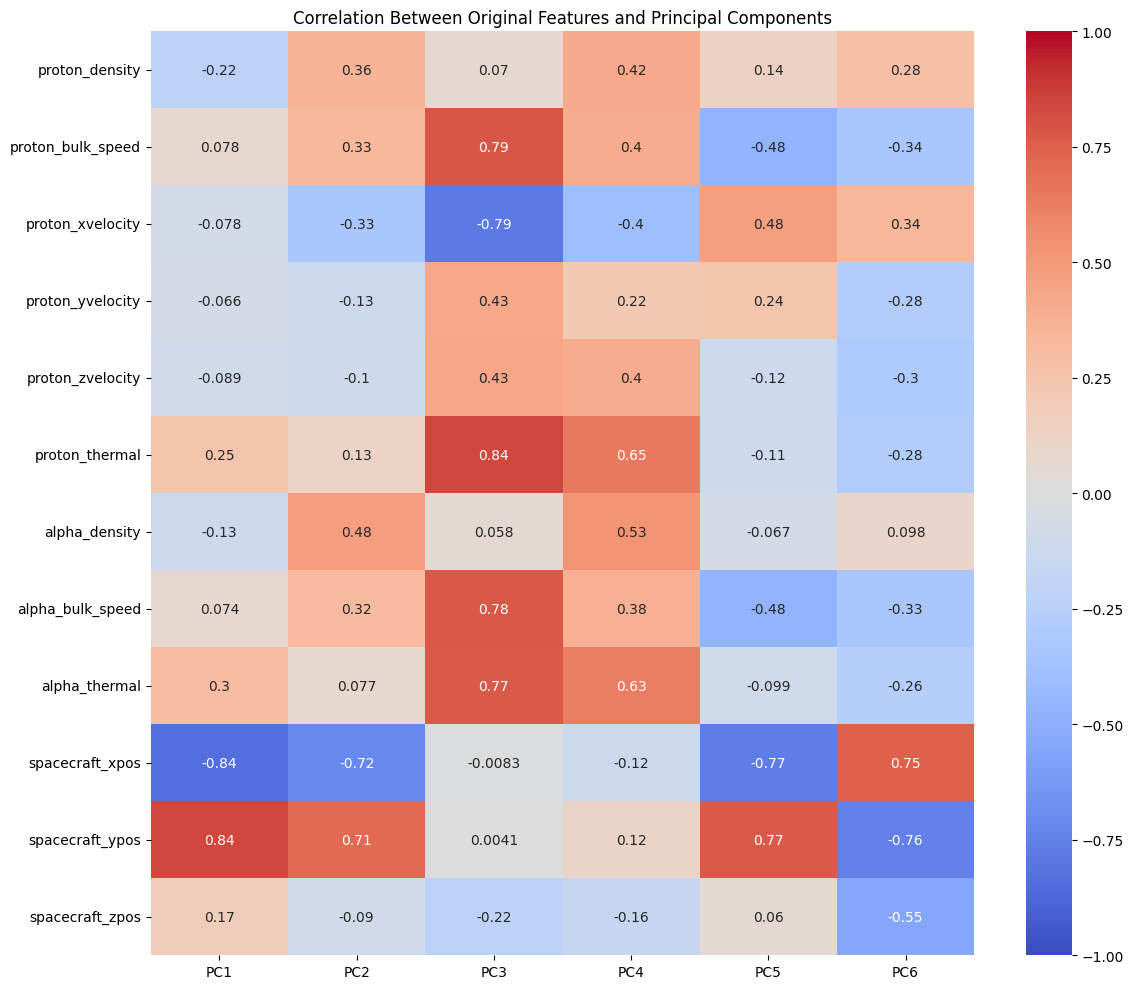

Model trained successfully. Explained variance: 0.9772


In [33]:
# Example usage
if __name__ == "__main__":
    file_path = "/Users/vishrutgupta/Desktop/ISRO_bah_2025/merged_data_combined.csv"
    data = pd.read_csv(file_path, na_values=[-1e+31, '-1e+31'])
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna()
    cols_to_drop = ['epoch_for_cdf_mod', 'CME', 'HALO']
    original_data = data.drop(columns = cols_to_drop)
    
    # Run the non-linear PCA
    encoder, autoencoder, encoded_data, explained_variance = run_nonlinear_pca(
        original_data, 
        encoding_dim=6,
        epochs = 1000,
        batch_size = 10000
    )

    print(f"Model trained successfully. Explained variance: {explained_variance:.4f}")

In [34]:
# # Save the encoded data to a new CSV file
encoded_df = pd.DataFrame(encoded_data, columns=[f'PC{i+1}' for i in range(encoded_data.shape[1])])
encoded_df = encoded_df.round(4)
add_column1 = data['CME']
add_column2 = data['HALO']
if add_column1 is not None and len(add_column1) == len(encoded_df):
    encoded_df['CME'] = add_column1.reset_index(drop=True)
    encoded_df['HALO'] = add_column2.reset_index(drop=True)
    print("columns successfully appended.")
else:
    print("Warning: columns not appended due to length mismatch or missing column.")


encoded_df.to_csv("nlpca_98perc_6pc.csv", index=False)
print("Encoded data saved successfully.")


columns successfully appended.
Encoded data saved successfully.
